In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import cartopy.io.shapereader as shpreader
import metpy
from metpy.plots import SkewT
from metpy.units import units
from metpy.plots import Hodograph
import metpy.calc as mpcalc
import sklearn
import math
from sklearn.metrics import jaccard_score

In [8]:
lt_data = xr.open_dataset('./dados2/lmarço2021.nc', engine="netcdf4")
t_data = xr.open_dataset('./dados2/março2021.nc', engine="netcdf4")

In [48]:
d =18


lo = 22
la = 10

T = (lt_data.t[d,:,la,lo].values-273.15)
r = (lt_data.r[d,:,la,lo].values)
td = T - ((100 - r)/5)
p = lt_data.level.values
u = (lt_data.u[d,:,la,lo].values*1.944)
v = (lt_data.v[d,:,la,lo].values*1.944)

z  = (lt_data.z[d,:,la,lo].values/9.80665)
z = list(reversed(z)) * units.meters


r = list(reversed(r)) *units.percent
p = list(reversed(p)) * units.hPa
T = list(reversed(T)) * units.degC
Td = list(reversed(td)) * units.degC
u = list(reversed(u)) * units.knots
v = list(reversed(v)) * units.knots

In [49]:
rh = r/100 * units.dimensionless
Td = mpcalc.dewpoint_from_relative_humidity(T, rh)
print(Td)


[-36.87371826171875 -37.68299865722656 -38.19561767578125 -39.998748779296875 -41.714569091796875 -42.133453369140625 -42.75360107421875 -43.422515869140625 -44.134735107421875 -44.98948669433594 -45.98405456542969 -47.532867431640625 -48.69105529785156 -50.91355895996094 -53.768646240234375 -56.695953369140625 -60.178009033203125 -62.720184326171875 -66.18797302246094 -71.13150024414062 -78.39253234863281 -82.58663940429688 -86.95315551757812 -91.40835571289062 -97.220458984375 -104.84146118164062 -106.2620849609375 -107.12117004394531 -108.73297119140625 -111.13227844238281 -112.79296875 -115.43081665039062 -117.12173461914062 -118.28643798828125 -118.62228393554688 -124.89617919921875 -121.95904541015625] degree_Celsius


In [50]:

prof = mpcalc.parcel_profile(p, T[0], Td[0])
mucape, mucin = mpcalc.most_unstable_cape_cin(p, T, Td)
sucape, sucin = mpcalc.surface_based_cape_cin(p,T,Td)
cape, cin = mpcalc.cape_cin(p, T, Td, prof)

print(mucape) 
print(sucape)
print(cape)
print(t_data.cape[d,la,lo].values)


0 joule / kilogram
0 joule / kilogram
0 joule / kilogram
1540.1265


NameError: name 'local' is not defined

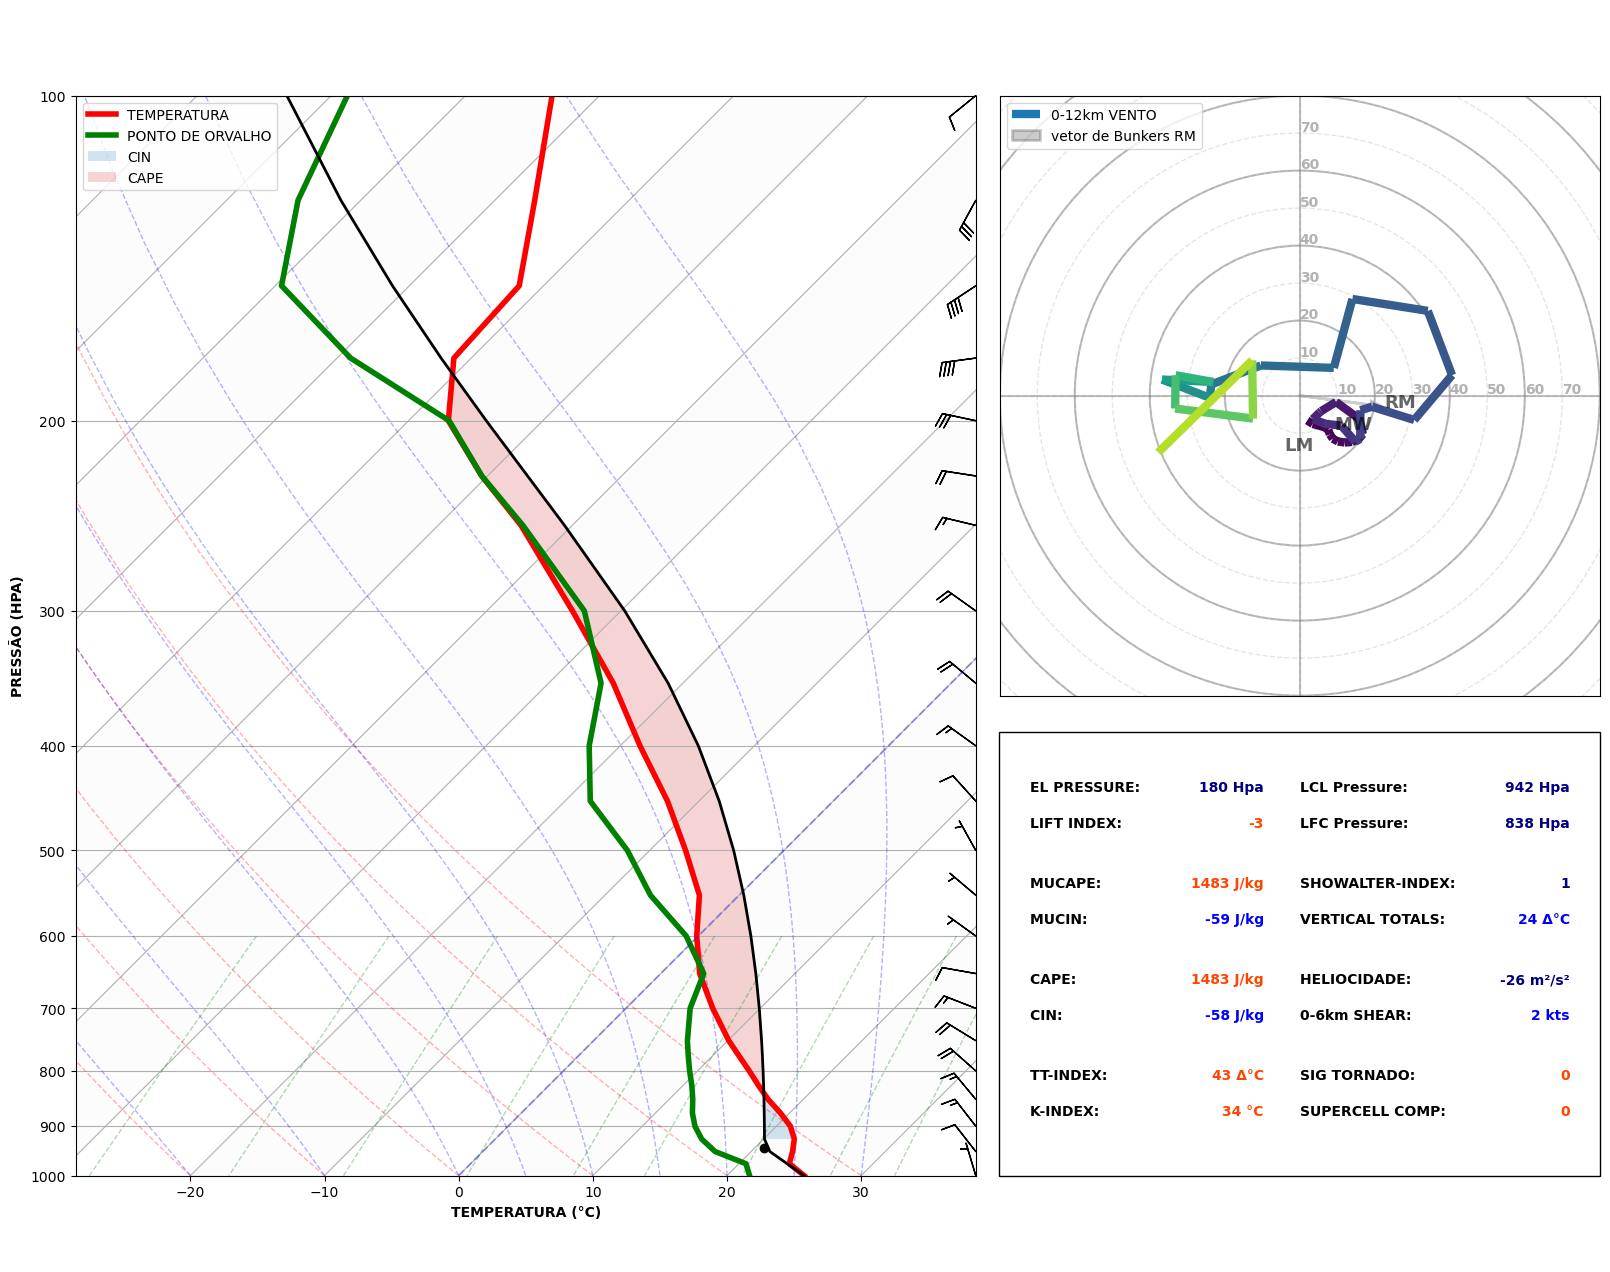

In [6]:


'''
    STEP 1: CREATE THE SKEW-T OBJECT AND MODIFY IT TO CREATE A NICE, CLEAN PLOT
'''

# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(18,12))
skew = SkewT(fig, rotation=45, rect=(0, 0, 0.50, 0.90))

# Change to adjust data limits and give it a semblance of what we want
skew.ax.set_adjustable('datalim')
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-20, 30)

# Set some better labels than the default to increase readability
skew.ax.set_xlabel(str.upper(f'Temperatura ({T.units:~P})'), weight='bold')
skew.ax.set_ylabel(str.upper(f'Pressão ({p.units:~P})'), weight='bold')

# Set the facecolor of the Skew Object and the Figure to white
fig.set_facecolor('#ffffff')
skew.ax.set_facecolor('#ffffff')

# Here we can use some basic math and python functionality to make a cool
# shaded isotherm pattern.
x1 = np.linspace(-100, 40, 8)
x2 = np.linspace(-90, 50, 8)
y = [1100, 50]
for i in range(0, 8):
    skew.shade_area(y=y, x1=x1[i], x2=x2[i], color='gray', alpha=0.02, zorder=1)

'''
    STEP 2: PLOT DATA ON THE SKEW-T. TAKE A COUPLE EXTRA STEPS TO INCREASE READABILITY
'''

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plotm
# set the linewidth to 4 for increased readability.
# We will also add the 'label' kew word argument for our legend.
skew.plot(p, T, 'r', lw=4, label='TEMPERATURA')
skew.plot(p, Td, 'g', lw=4, label='PONTO DE ORVALHO')

# again we can use some simple python math functionality to 'resample'
# the wind barbs for a cleaner output with increased readability.
# Something like this would work.
interval = np.logspace(2, 3, 40) * units.hPa
idx = mpcalc.resample_nn_1d(p, interval)
skew.plot_barbs(pressure=p[idx], u=u[idx], v=v[idx], flip_barb=True)

# Add the relevant special lines native to the Skew-T Log-P diagram &
# provide basic adjustments to linewidth and alpha to increase readability
# first we add a matplotlib axvline to highlight the 0 degree isotherm
skew.ax.axvline(0 * units.degC, linestyle='--', color='blue', alpha=0.3)
skew.plot_dry_adiabats(lw=1, alpha=0.3)
skew.plot_moist_adiabats(lw=1, alpha=0.3)
skew.plot_mixing_lines(lw=1, alpha=0.3)

# Calculate LCL height and plot as black dot. Because `p`'s first value is
# ~1000 mb and its last value is ~250 mb, the `0` index is selected for
# `p`, `T`, and `Td` to lift the parcel from the surface. If `p` was inverted,
# i.e. start from low value, 250 mb, to a high value, 1000 mb, the `-1` index
# should be selected.
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(p, T[1], Td[1])
skew.plot(p, prof, 'k', linewidth=2,)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, prof, Td, alpha=0.2, label='CIN')
skew.shade_cape(p, T, prof, alpha=0.2, label='CAPE')



'''
    STEP 3: CREATE THE HODOGRAPH INSET. TAKE A FEW EXTRA STEPS TO INCREASE READABILITY
'''

# Create a hodograph object: first we need to add an axis
# then we can create the metpy Hodograph
hodo_ax = plt.axes((0.43, 0.40, 0.5, 0.5))
h = Hodograph(hodo_ax, component_range=80.)
# Add two seperate grid increments for a cooler look. This also
# helps to increase readability
h.add_grid(increment=20, ls='-', lw=1.5, alpha=0.5)
h.add_grid(increment=10, ls='--', lw=1, alpha=0.2)
# The next few steps makes for a clean hodograph inset, removing the
# tick marks, tick labels and axis labels
h.ax.set_box_aspect(1)
h.ax.set_yticklabels([])
h.ax.set_xticklabels([])
h.ax.set_xticks([])
h.ax.set_yticks([])
h.ax.set_xlabel(' ')
h.ax.set_ylabel(' ')

# Here we can add a simple python for loop that adds tick marks to the inside
# of the hodograph plot to increase readability!
plt.xticks(np.arange(0,0,1))
plt.yticks(np.arange(0,0,1))
for i in range(10,120,10):
    h.ax.annotate(str(i),(i,0),xytext=(0,2),textcoords='offset pixels',clip_on=True,fontsize=10,weight='bold',alpha=0.3,zorder=0)
for i in range(10,120,10):
    h.ax.annotate(str(i),(0,i),xytext=(0,2),textcoords='offset pixels',clip_on=True,fontsize=10,weight='bold',alpha=0.3,zorder=0)

# plot the hodograph itself, using plot_colormapped, colored
# by height
h.plot_colormapped(u, v, c=z, linewidth=6, label="0-12km VENTO")
# compute Bunkers storm motion so we can plot it on the hodograph!
RM, LM, MW = mpcalc.bunkers_storm_motion(p, u, v, z)
h.ax.text((RM[0].m +0.5), (RM[1].m -0.5), 'RM', weight='bold', ha='left', fontsize=13, alpha=0.6)
h.ax.text((LM[0].m +0.5), (LM[1].m -0.5), 'LM', weight='bold', ha='left', fontsize=13, alpha=0.6)
h.ax.text((MW[0].m +0.5), (MW[1].m -0.5), 'MW', weight='bold', ha='left', fontsize=13, alpha=0.6)
h.ax.arrow(0,0,RM[0].m-0.3, RM[1].m-0.3, linewidth=2, color='black', alpha=0.2, label='vetor de Bunkers RM',
          length_includes_head=True, head_width=2)



'''
    STEP 4: ADD A FEW EXTRA ELEMENTS TO REALLY MAKE A NEAT PLOT
'''
# First we want to actually add values of data to the plot for easy viewing
# to do this, lets first add a simple rectangle using matplotlib's 'patches'
# fucntionality to add some simple layout for plotting calculated parameters
#                                  xloc   yloc   xsize  ysize
fig.patches.extend([plt.Rectangle((0.513, 0.00), 0.334, 0.37,
                                  edgecolor='black', facecolor='white', linewidth=1, alpha=1,
                                  transform=fig.transFigure, figure=fig)])

# now lets take a moment to calculate some simple severe-weather parameters using
# metpy's calculations 
# here are some classic severe parameters!
kindex = mpcalc.k_index(p, T, Td)
total_totals = mpcalc.total_totals_index(p, T, Td)

# mixed layer parcel properties!
ml_t, ml_td = mpcalc.mixed_layer(p, T, Td, depth=50 * units.hPa)
ml_p, _, _ = mpcalc.mixed_parcel(p, T, Td, depth=50 * units.hPa)
mlcape, mlcin = mpcalc.mixed_layer_cape_cin(p, T, prof)

# most unstable parcel properties!
mu_p, mu_t, mu_td, _ = mpcalc.most_unstable_parcel(p, T, Td, depth=50 * units.hPa)

mucape, mucin = mpcalc.most_unstable_cape_cin(p, T, prof, depth=50 * units.hPa)

# Estimate height of LCL in meters from hydrostatic thickness (for sig_tor)
new_p = np.append(p[p > lcl_pressure], lcl_pressure)
new_t = np.append(T[p > lcl_pressure], lcl_temperature)
lcl_height = mpcalc.thickness_hydrostatic(new_p, new_t)

# Compute Surface-based CAPE
sbcape, sbcin = mpcalc.surface_based_cape_cin(p, T, Td)

# Compute SRH 
(u_storm, v_storm), *_ = mpcalc.bunkers_storm_motion(p, u, v, z)
*_, total_helicity1 = mpcalc.storm_relative_helicity(z, u, v, depth=1 * units.km,
                                                    storm_u=u_storm, storm_v=v_storm)
*_, total_helicity3 = mpcalc.storm_relative_helicity(z, u, v, depth=3 * units.km,
                                                    storm_u=u_storm, storm_v=v_storm)
*_, total_helicity6 = mpcalc.storm_relative_helicity(z, u, v, depth=6 * units.km,
                                                    storm_u=u_storm, storm_v=v_storm)

# Copmute Bulk Shear components and then magnitude
ubshr1, vbshr1 = mpcalc.bulk_shear(p, u, v, height=z, depth=1 * units.km)
bshear1 = mpcalc.wind_speed(ubshr1, vbshr1)
ubshr3, vbshr3 = mpcalc.bulk_shear(p, u, v, height=z, depth=3 * units.km)
bshear3 = mpcalc.wind_speed(ubshr3, vbshr3)
ubshr6, vbshr6 = mpcalc.bulk_shear(p, u, v, height=z, depth=6 * units.km)
bshear6 = mpcalc.wind_speed(ubshr6, vbshr6)

# Use all computed pieces to calculate the Significant Tornado parameter
sig_tor = mpcalc.significant_tornado(sbcape, lcl_height,
                                     total_helicity3, bshear3).to_base_units()

# Perform the calculation of supercell composite if an effective layer exists
super_comp = mpcalc.supercell_composite(mucape, total_helicity3, bshear3)

*_, total_helicity = mpcalc.storm_relative_helicity(z, u, v, depth=1 * units.km,
                                                    storm_u=u_storm, storm_v=v_storm)

ctotals = mpcalc.cross_totals(p, T, Td)
kindex = mpcalc.k_index(p, T, Td)
showalter = mpcalc.showalter_index(p, T, Td)
total_totals = mpcalc.total_totals_index(p, T, Td)
vert_totals = mpcalc.vertical_totals(p, T)
el_pressure, _ = mpcalc.el(p, T, Td, prof)
lift_index = mpcalc.lifted_index(p, T, prof)
lclp, lclt = mpcalc.lcl(p[0], T[0], Td[0])
lfcp, _ = mpcalc.lfc(p, T, Td)
cape, cin = mpcalc.cape_cin(p, T, Td, prof)
mucape, mucin = mpcalc.most_unstable_cape_cin(p, T, Td, depth=50 * units.hPa)

plt.figtext( 0.53, 0.32,  f'EL PRESSURE: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext( 0.66, 0.32,  f'{int(el_pressure.m)} Hpa', weight='bold', fontsize=10, color='navy', ha='right')
plt.figtext( 0.53, 0.29,  f'LIFT INDEX: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext( 0.66, 0.29,  f'{int(lift_index.m)}', weight='bold', fontsize=10, color='orangered', ha='right')

plt.figtext( 0.53, 0.24,  f'MUCAPE: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext( 0.66, 0.24,  f'{int(mucape.m)} J/kg', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext( 0.53, 0.21,  f'MUCIN: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext( 0.66, 0.21,  f'{int(mucin.m)} J/kg', weight='bold', fontsize=10, color='blue', ha='right')

plt.figtext( 0.53, 0.16,  f'CAPE: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext( 0.66, 0.16,  f'{int(cape.m)} J/kg', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext( 0.53, 0.13,  f'CIN: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext( 0.66, 0.13,  f'{int(cin.m)} J/kg', weight='bold', fontsize=10, color='blue', ha='right')

plt.figtext( 0.53, 0.08,  f'TT-INDEX: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext( 0.66, 0.08,  f'{int(total_totals.m)} Δ°C', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext( 0.53, 0.05,  f'K-INDEX: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext( 0.66, 0.05,  f'{int(kindex.m)} °C', weight='bold', fontsize=10, color='orangered', ha='right')

# now some kinematic parameters
met_per_sec = (units.m*units.m)/(units.sec*units.sec)
plt.figtext( 0.68, 0.32,  f'LCL Pressure: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext( 0.83, 0.32,  f'{int(lclp.m)} Hpa', weight='bold', fontsize=10, color='navy', ha='right')
plt.figtext( 0.68, 0.29,  f'LFC Pressure: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext( 0.83, 0.29,  f'{int(lfcp.m)} Hpa', weight='bold', fontsize=10, color='navy', ha='right')

plt.figtext( 0.68, 0.24,  f'SHOWALTER-INDEX: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext( 0.83, 0.24,  f'{int(showalter.m)}', weight='bold', fontsize=10, color='navy', ha='right')
plt.figtext( 0.68, 0.21,  f'VERTICAL TOTALS: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext( 0.83, 0.21,  f'{int(vert_totals.m) } Δ°C', weight='bold', fontsize=10, color='blue', ha='right')

plt.figtext( 0.68, 0.16,  f'HELIOCIDADE: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext( 0.83, 0.16,  f'{int(total_helicity.m)* met_per_sec:~P}', weight='bold', fontsize=10, color='navy', ha='right')
plt.figtext( 0.68, 0.13,  f'0-6km SHEAR: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext( 0.83, 0.13,  f'{int(bshear6.m)} kts', weight='bold', fontsize=10, color='blue', ha='right')

plt.figtext( 0.68, 0.08,  f'SIG TORNADO: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext( 0.83, 0.08,  f'{int(sig_tor.m)}', weight='bold', fontsize=10, color='orangered', ha='right')
plt.figtext( 0.68, 0.05,  f'SUPERCELL COMP: ', weight='bold', fontsize=10, color='black', ha='left')
plt.figtext( 0.83, 0.05,  f'{int(super_comp.m)}', weight='bold', fontsize=10, color='orangered', ha='right')

# add legends to the skew and hodo
skewleg = skew.ax.legend(loc='upper left')
hodoleg = h.ax.legend(loc='upper left')

# add a plot title
plt.figtext( 0.40, 0.92,  f'Skew-T | {local} {data}', weight='bold', fontsize=20, ha='center')
# Show the plot
plt.show()

https://unidata.github.io/MetPy/latest/examples/calculations/Sounding_Calculations.html#sphx-glr-examples-calculations-sounding-calculations-py

In [17]:
mucape, mucin = mpcalc.most_unstable_cape_cin(p, T, Td, depth=50 * units.hPa)
sucape, sucin = mpcalc.surface_based_cape_cin(p,T,Td)
print(mucape) 
print(sucape)
print(t_data.cape[d,la,lo].values)



1483.2935878581106 joule / kilogram
1483.2935878581106 joule / kilogram
1532.8613
